### Imports

In [45]:
# Utilities
import os
import datetime

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import requests
import getpass
from dataclasses import dataclass

from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubCatalog,
    SentinelHubRequest,
    BBox,
    bbox_to_dimensions,
    CRS,
    MimeType,
    Geometry,
)

# from utils import plot_image

### Generate Token
* Get credentials from environment variables
* Input creds to function from Copernicus

In [2]:
username = os.environ["SENTINEL_USER"]
password = os.environ["SENTINEL_PW"]

In [ ]:
# Import credentials
# from creds import *


def get_access_token(username: str, password: str) -> str:
    data = {
        "client_id": "cdse-public",
        "username": username,
        "password": password,
        "grant_type": "password",
    }
    try:
        r = requests.post(
            "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token",
            data=data,
        )
        r.raise_for_status()
    except Exception as e:
        raise Exception(
            f"Access token creation failed. Reponse from the server was: {r.json()}"
        )
    return r.json()["access_token"]


access_token = get_access_token(username, password)


access_token = get_access_token(
    getpass.getpass("Enter your username"),
    getpass.getpass("Enter your password"),
)

### Catalog API

In [46]:
# Only run this cell if you have not created a configuration.

config = SHConfig()
config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")
config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
config.save("cdse")

In [47]:
aoi_coords_wgs84 = [4.20762, 50.764694, 4.487708, 50.916455]
resolution = 10
aoi_bbox = BBox(bbox=aoi_coords_wgs84, crs=CRS.WGS84)
aoi_size = bbox_to_dimensions(aoi_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {aoi_size} pixels")

Image shape at 10 m resolution: (1941, 1723) pixels


In [10]:
catalog = SentinelHubCatalog(config=config)

In [11]:
aoi_bbox = BBox(bbox=aoi_coords_wgs84, crs=CRS.WGS84)
time_interval = "2022-07-01", "2022-07-20"

search_iterator = catalog.search(
    DataCollection.SENTINEL2_L2A,
    bbox=aoi_bbox,
    time=time_interval,
    fields={"include": ["id", "properties.datetime"], "exclude": []},
)

results = list(search_iterator)
print("Total number of results:", len(results))

results

Total number of results: 16


[{'id': 'S2A_MSIL2A_20220719T105041_N0400_R051_T31UES_20220719T170208.SAFE',
  'properties': {'datetime': '2022-07-19T10:57:07.477Z'}},
 {'id': 'S2A_MSIL2A_20220719T105041_N0400_R051_T31UFS_20220719T170208.SAFE',
  'properties': {'datetime': '2022-07-19T10:57:03.296Z'}},
 {'id': 'S2A_MSIL2A_20220716T103641_N0400_R008_T31UES_20220716T183414.SAFE',
  'properties': {'datetime': '2022-07-16T10:47:11.385Z'}},
 {'id': 'S2A_MSIL2A_20220716T103641_N0400_R008_T31UFS_20220716T183414.SAFE',
  'properties': {'datetime': '2022-07-16T10:47:07.153Z'}},
 {'id': 'S2B_MSIL2A_20220714T104629_N0400_R051_T31UES_20220714T134329.SAFE',
  'properties': {'datetime': '2022-07-14T10:57:00.047Z'}},
 {'id': 'S2B_MSIL2A_20220714T104629_N0400_R051_T31UFS_20220714T134329.SAFE',
  'properties': {'datetime': '2022-07-14T10:56:55.872Z'}},
 {'id': 'S2B_MSIL2A_20220711T103629_N0400_R008_T31UES_20220711T121934.SAFE',
  'properties': {'datetime': '2022-07-11T10:47:03.695Z'}},
 {'id': 'S2B_MSIL2A_20220711T103629_N0400_R008_T

### Process API
* Establish config, input data, bbox, size, etc.
* Write evalscript
* Pass these as input to the SentinelHubRequest
* SentinelHubRequest.get_data() which will output the image from the requested time interval as *numpy arrays*

In [48]:
@dataclass
class RequestInput:
    """
        Dataclass representing the inputs for SentinelHubRequest
    """
    evalscript: str
    # data_collection: DataCollection
    data_collection_name: str
    data_collection_url: str
    time_interval: tuple[str]
    other_args: dict
    responses: list
    bbox: BBox
    size: tuple
    config: SHConfig


In [ ]:
# Only run this cell if you have not created a configuration.

config = SHConfig()
config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")
config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
config.save("cdse")

##### True Color

In [121]:


evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""
# Example
aoi_coords_wgs84 = [4.20762, 50.764694, 4.487708, 50.916455]
# Asia
# aoi_coords_wgs84 = [-29.99, -30.01, -90.0, 90.0]

resolution = 8
aoi_bbox = BBox(bbox=aoi_coords_wgs84, crs=CRS.WGS84)
aoi_size = bbox_to_dimensions(aoi_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {aoi_size} pixels")

Image shape at 8 m resolution: (2426, 2154) pixels


NVDI

##### RequestInput and SentinelHubRequest

In [122]:
request_input_true = RequestInput(
    evalscript=evalscript_true_color,
    data_collection_name="s2",
    data_collection_url="https://sh.dataspace.copernicus.eu",
    time_interval=("2022-07-01", "2022-10-20"),
    other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=aoi_bbox,
    size=aoi_size,
    config=config
)

In [123]:
request_true_color = SentinelHubRequest(
    evalscript=request_input_true.evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                name=request_input_true.data_collection_name,
                service_url=request_input_true.data_collection_url
            ),
            time_interval=request_input_true.time_interval,
            other_args=request_input_true.other_args,
        )
    ],
    responses=request_input_true.responses,
    bbox=request_input_true.bbox,
    size=request_input_true.size,
    config=request_input_true.config,
)

In [ ]:
request_true_color.save_data()

In [124]:
true_color_imgs = request_true_color.get_data()

In [91]:
print(f"Type: {type(true_color_imgs[0])}")
print(f"Length of true_color_imgs is: {len(true_color_imgs)}")
print(f"Shape: {true_color_imgs[0].shape}")

Type: <class 'numpy.ndarray'>
Length of true_color_imgs is: 1
Shape: (1723, 1941, 3)


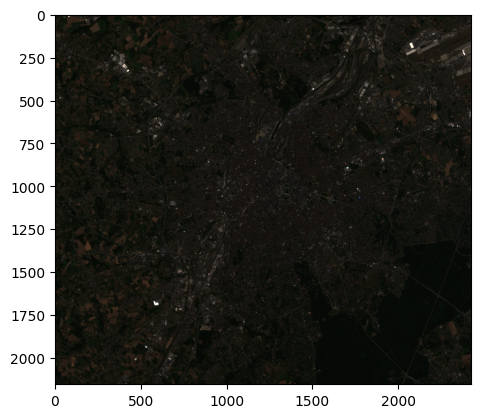

In [125]:
image = true_color_imgs[0]
# image = img

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
# plot_image(image, factor=3.5 / 255, clip_range=(0, 1))

# plt.imshow(image, cmap="viridis", interpolation="nearest")
# plt.imshow(image, vmin=3, vmax=6)
plt.imshow(image)
plt.show()